# 图注意力网络

In [2]:
 import numpy as np
 np.random.seed(0)

 A = np.array([
    [1,1,1,1],
    [1,1,0,0],
    [1,0,1,1],
    [1,0,1,1]
 ])
print(A)

[[1 1 1 1]
 [1 1 0 0]
 [1 0 1 1]
 [1 0 1 1]]


In [3]:
X = np.random.uniform(-1, 1, (4, 4))

print(X)

[[ 0.09762701  0.43037873  0.20552675  0.08976637]
 [-0.1526904   0.29178823 -0.12482558  0.783546  ]
 [ 0.92732552 -0.23311696  0.58345008  0.05778984]
 [ 0.13608912  0.85119328 -0.85792788 -0.8257414 ]]


In [ ]:
W = np.random.uniform(-1, 1, (2, 4)) #常规权重矩阵

print(W)





[[-0.95956321  0.66523969  0.5563135   0.7400243 ]
 [ 0.95723668  0.59831713 -0.07704128  0.56105835]]


In [ ]:
W_att = np.random.uniform(-1, 1, (1, 4)) #注意力权重矩阵

print(W_att)

[[0.22419145 0.23386799 0.88749616 0.3636406 ]]


In [12]:
connections =np.where(A > 0)

print(connections)

(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]), array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))


In [13]:
np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]],axis=1)

array([[ 0.37339233,  0.38548525,  0.37339233,  0.38548525],
       [ 0.37339233,  0.38548525,  0.85102612,  0.47765279],
       [ 0.37339233,  0.38548525, -0.67755906,  0.73566587],
       [ 0.37339233,  0.38548525, -0.65268413,  0.24235977],
       [ 0.85102612,  0.47765279,  0.37339233,  0.38548525],
       [ 0.85102612,  0.47765279,  0.85102612,  0.47765279],
       [-0.67755906,  0.73566587,  0.37339233,  0.38548525],
       [-0.67755906,  0.73566587, -0.67755906,  0.73566587],
       [-0.67755906,  0.73566587, -0.65268413,  0.24235977],
       [-0.65268413,  0.24235977,  0.37339233,  0.38548525],
       [-0.65268413,  0.24235977, -0.67755906,  0.73566587],
       [-0.65268413,  0.24235977, -0.65268413,  0.24235977]])

In [17]:
a = W_att @ np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]],axis=1).T

print(a)

[[ 0.64542637  1.10284039 -0.15994906 -0.31725878  0.77406282  1.23147684
   0.4917081  -0.31366733 -0.47097705  0.38191634 -0.42345909 -0.58076881]]


In [18]:
def leaky_relu(x, alpha=0.2):
    return np.maximum(alpha * x, x)

e = leaky_relu(a)

print(e)





[[ 0.64542637  1.10284039 -0.03198981 -0.06345176  0.77406282  1.23147684
   0.4917081  -0.06273347 -0.09419541  0.38191634 -0.08469182 -0.11615376]]


In [19]:
E = np.zeros(A.shape)
E[connections[0], connections[1]] = e[0]

print(E)

[[ 0.64542637  1.10284039 -0.03198981 -0.06345176]
 [ 0.77406282  1.23147684  0.          0.        ]
 [ 0.4917081   0.         -0.06273347 -0.09419541]
 [ 0.38191634  0.         -0.08469182 -0.11615376]]


In [20]:
def softmax2D(x, axis):
    e = np.exp(x - np.expand_dims(np.max(x, axis=axis), axis))
    sum = np.expand_dims(np.sum(e, axis=axis), axis)
    return e / sum

W_alpha = softmax2D(E, 1)
print(W_alpha)







[[0.27932129 0.44132286 0.14187502 0.13748084]
 [0.28553037 0.4511331  0.13166826 0.13166826]
 [0.36462064 0.222995   0.20943552 0.20294884]
 [0.34277328 0.23396064 0.21496196 0.20830412]]


In [21]:
H = A.T @ W_alpha @ X @ W.T

print(H)





[[0.70644755 1.8133354 ]
 [0.60940354 0.91049343]
 [0.39105745 1.35900773]
 [0.39105745 1.35900773]]


## 在Pytorch Geomatric 实现图注意力网络

In [27]:
from torch_geometric.datasets import Planetoid


In [24]:
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [31]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch.nn import Linear, Dropout

def accuracy(pred, y):
    return ((pred == y).sum() / len(y)).item()

In [34]:
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=1)
    
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.test_mask].argmax(dim=1), data.y[data.test_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

                print(f"Epoch {epoch:>3}, Loss: {loss:.2f}, Val Loss: {val_loss:.2f}, Accuracy: {acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%")
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out[data.test_mask].argmax(dim=1), data.y[data.test_mask])
        return acc
        
    

In [36]:
gat = GAT(data.num_features, 32, dataset.num_classes)
gat.fit(data, epochs=200)

Epoch   0, Loss: 1.96, Val Loss: 1.95, Accuracy: 13.50%, Val Accuracy: 16.60%
Epoch  20, Loss: 0.18, Val Loss: 0.94, Accuracy: 73.60%, Val Accuracy: 69.80%
Epoch  40, Loss: 0.15, Val Loss: 0.86, Accuracy: 73.90%, Val Accuracy: 71.60%
Epoch  60, Loss: 0.19, Val Loss: 0.84, Accuracy: 76.60%, Val Accuracy: 71.40%
Epoch  80, Loss: 0.16, Val Loss: 0.91, Accuracy: 75.00%, Val Accuracy: 73.60%
Epoch 100, Loss: 0.14, Val Loss: 0.98, Accuracy: 75.70%, Val Accuracy: 71.40%
Epoch 120, Loss: 0.15, Val Loss: 0.96, Accuracy: 76.40%, Val Accuracy: 72.20%
Epoch 140, Loss: 0.14, Val Loss: 0.91, Accuracy: 74.60%, Val Accuracy: 74.20%
Epoch 160, Loss: 0.15, Val Loss: 0.93, Accuracy: 76.20%, Val Accuracy: 72.80%
Epoch 180, Loss: 0.14, Val Loss: 0.88, Accuracy: 76.50%, Val Accuracy: 73.20%
Epoch 200, Loss: 0.14, Val Loss: 0.88, Accuracy: 77.60%, Val Accuracy: 73.60%


In [37]:
acc = gat.test(data)
print(f"Accuracy: {acc*100:.2f}%")






Accuracy: 81.90%


### 在CiteSeer数据集上使用图注意力网络

In [39]:
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

Processing...
Done!


In [40]:
print(data)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


In [43]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

<BarContainer object of 32 artists>

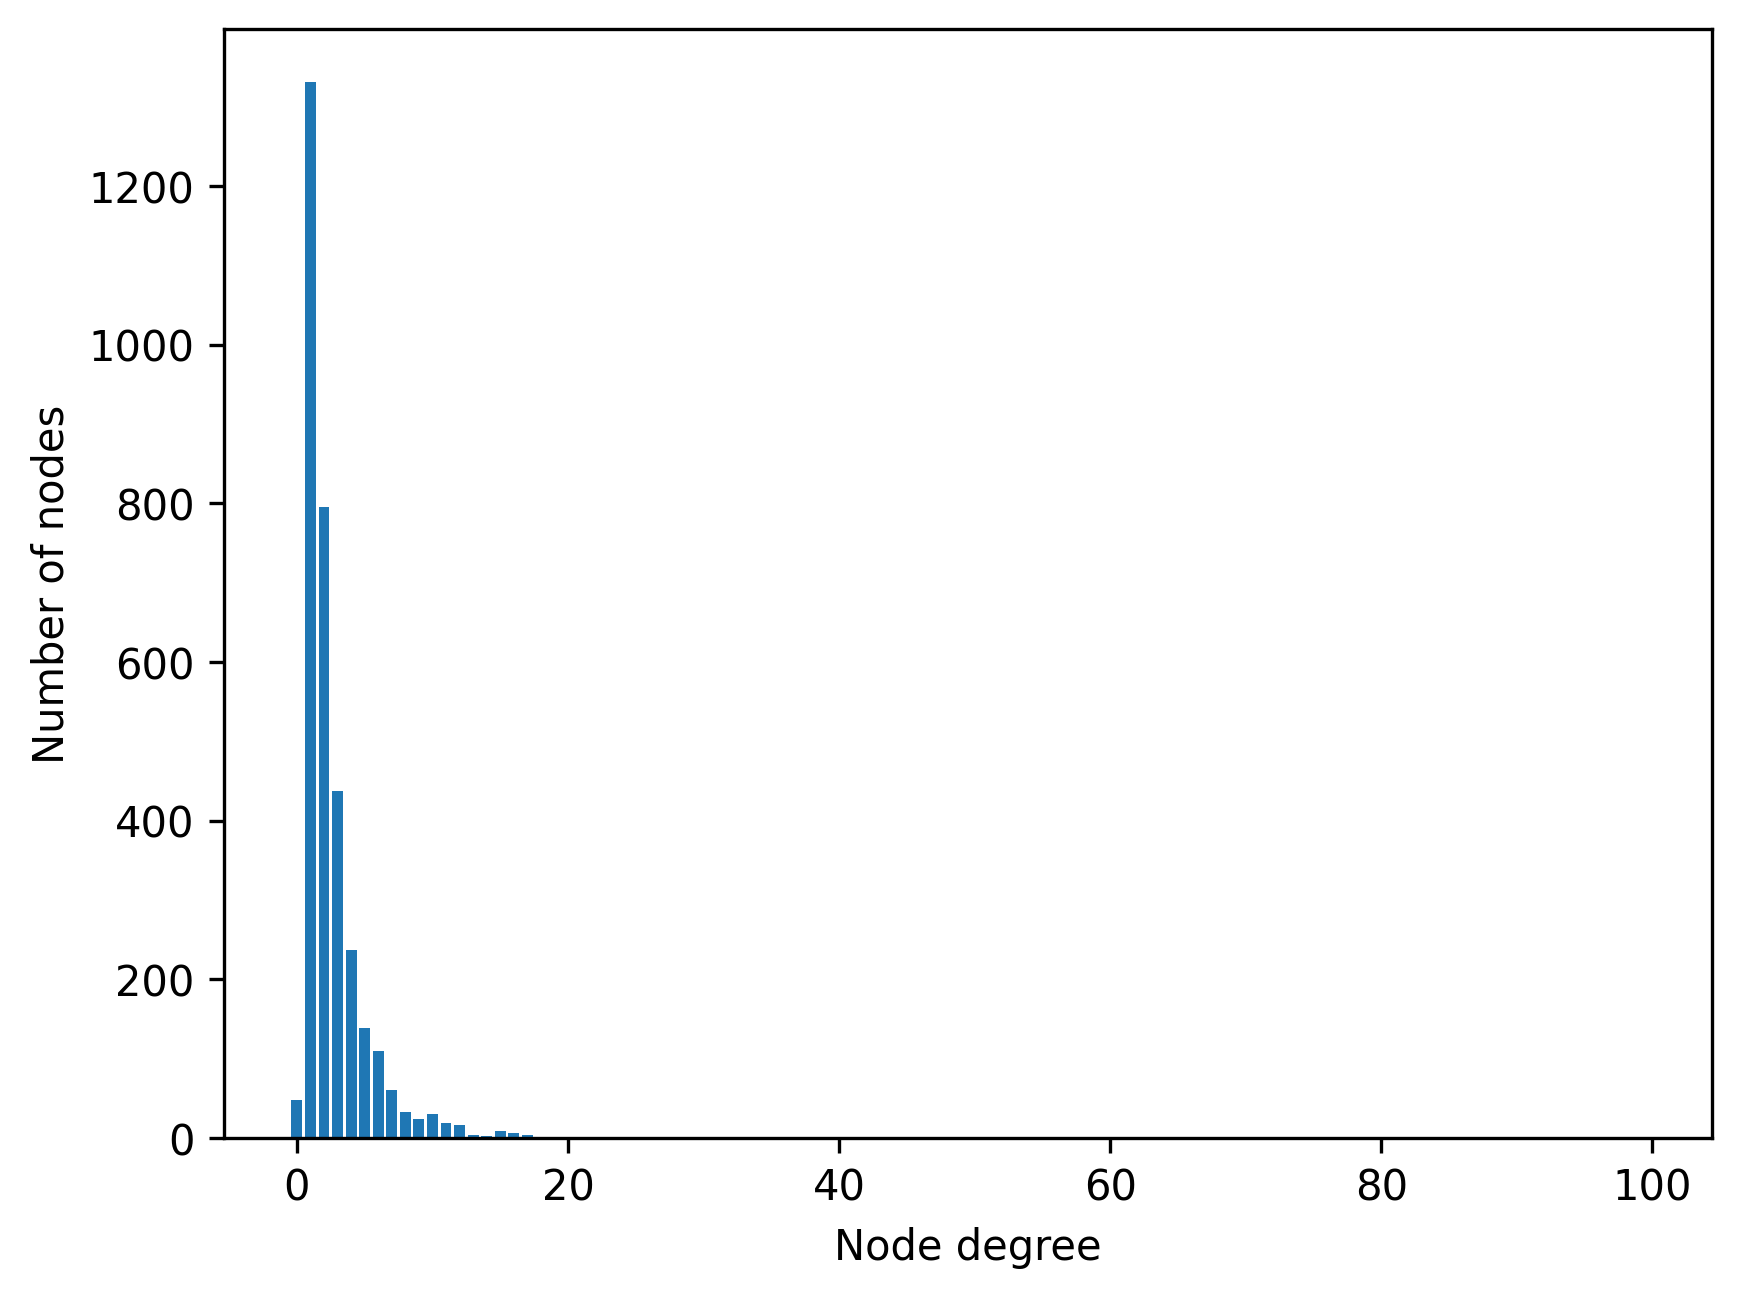

In [44]:
degrees =degree(dataset[0].edge_index[0]).numpy()

numbers = Counter(degrees)

fig, ax =plt.subplots(dpi=300)
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [46]:
gat = GAT(data.num_features, 16, dataset.num_classes)
gat.fit(data, epochs=200)

Epoch   0, Loss: 1.83, Val Loss: 1.81, Accuracy: 18.90%, Val Accuracy: 17.60%
Epoch  20, Loss: 0.18, Val Loss: 1.19, Accuracy: 63.50%, Val Accuracy: 62.40%
Epoch  40, Loss: 0.13, Val Loss: 1.15, Accuracy: 62.40%, Val Accuracy: 61.20%
Epoch  60, Loss: 0.11, Val Loss: 1.13, Accuracy: 62.40%, Val Accuracy: 63.20%
Epoch  80, Loss: 0.12, Val Loss: 1.13, Accuracy: 64.50%, Val Accuracy: 61.80%
Epoch 100, Loss: 0.10, Val Loss: 1.13, Accuracy: 61.20%, Val Accuracy: 64.00%
Epoch 120, Loss: 0.12, Val Loss: 1.13, Accuracy: 63.30%, Val Accuracy: 64.60%
Epoch 140, Loss: 0.10, Val Loss: 1.11, Accuracy: 64.00%, Val Accuracy: 66.00%
Epoch 160, Loss: 0.11, Val Loss: 1.11, Accuracy: 66.60%, Val Accuracy: 65.80%
Epoch 180, Loss: 0.12, Val Loss: 1.17, Accuracy: 62.40%, Val Accuracy: 61.40%
Epoch 200, Loss: 0.11, Val Loss: 1.21, Accuracy: 62.40%, Val Accuracy: 62.80%


In [47]:
acc = gat.test(data)
print(f"Accuracy: {acc*100:.2f}%")

Accuracy: 70.20%


In [49]:
out = gat(data.x, data.edge_index)
print(out)

tensor([[-4.8407, -4.2110, -3.8830, -0.0600, -4.7845, -5.0327],
        [-3.7571, -0.1098, -3.0339, -4.4640, -4.2363, -5.0315],
        [-5.6370, -6.7167, -5.2954, -4.5603, -6.3392, -0.0223],
        ...,
        [-4.2600, -3.0942, -1.6109, -0.3424, -4.0091, -4.3676],
        [-2.1020, -1.1016, -1.3894, -3.3840, -1.6576, -2.6352],
        [-3.6925, -5.2705, -4.7126, -4.9753, -5.0132, -0.0540]],
       grad_fn=<LogSoftmaxBackward0>)


In [51]:
degrees = degree(data.edge_index[0]).numpy()

accuracies = []
sizes =[]
for i in range(6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out[mask].argmax(dim=1), data.y[mask]))
    sizes.append(len(mask))

mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

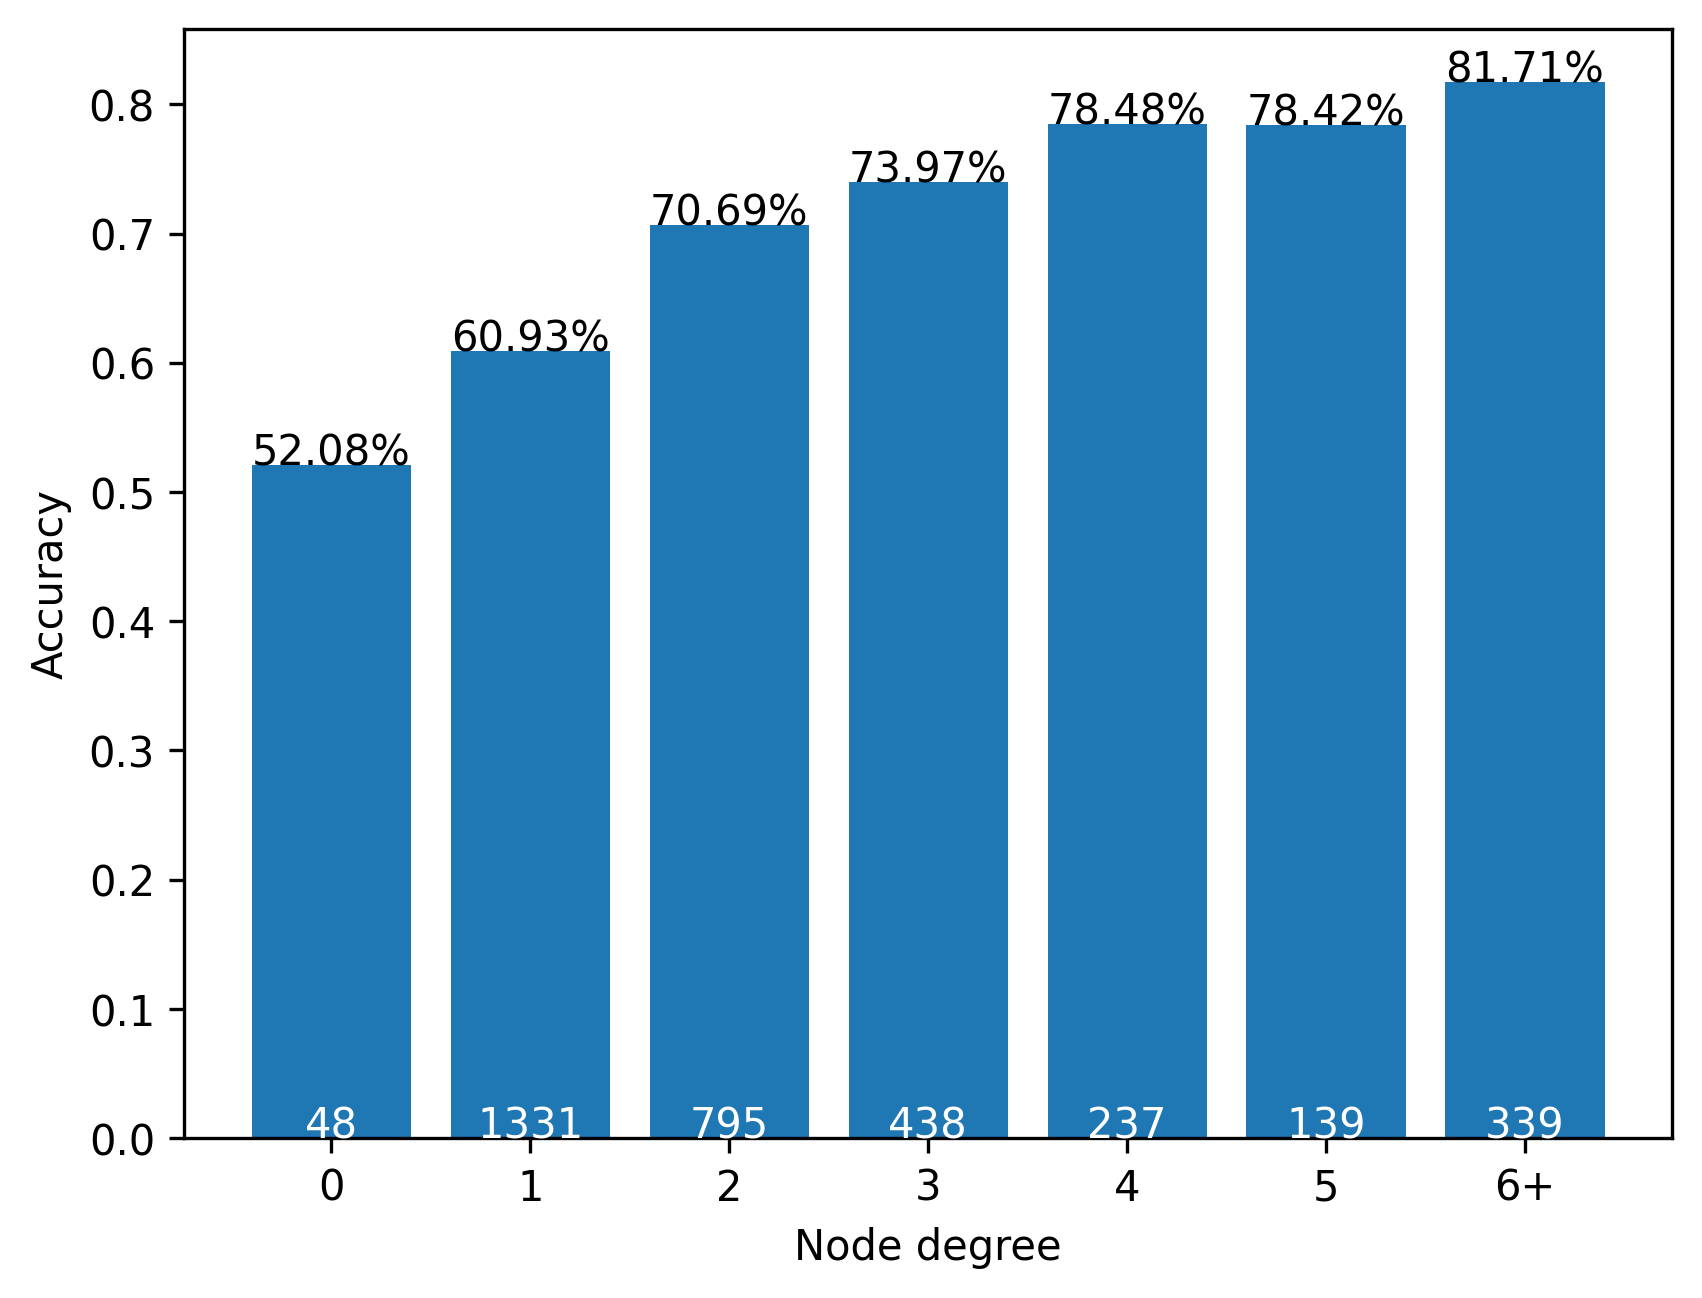

In [52]:
fig, ax = plt.subplots(dpi=300)
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy')
plt.bar(['0', '1', '2', '3', '4', '5', '6+'], accuracies)
for i in range(0,7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='black')

for i in range(0,7):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')

plt.show()

